
Before filtering: 13720 rows, 245 unique entities

Entities with highest percentage of zeros:
                                           Entity  ZeroPercentage
52                                 Czech Republic           100.0
37                                    Congo [DRC]           100.0
39                               Congo [Republic]           100.0
31                                  Bouvet Island           100.0
36                        Cocos [Keeling] Islands           100.0
41                                  Côte d'Ivoire           100.0
91                                     Gaza Strip           100.0
93              Heard Island and McDonald Islands           100.0
103                British Indian Ocean Territory           100.0
86   South Georgia and the South Sandwich Islands           100.0

Keeping 0 entities with 50% or less zeros

Filtered DataFrame:
Shape: (0, 40)
Columns: ['Entity', 'Year', 'GDP per capita, PPP (constant 2021 international $)', 'Urban population

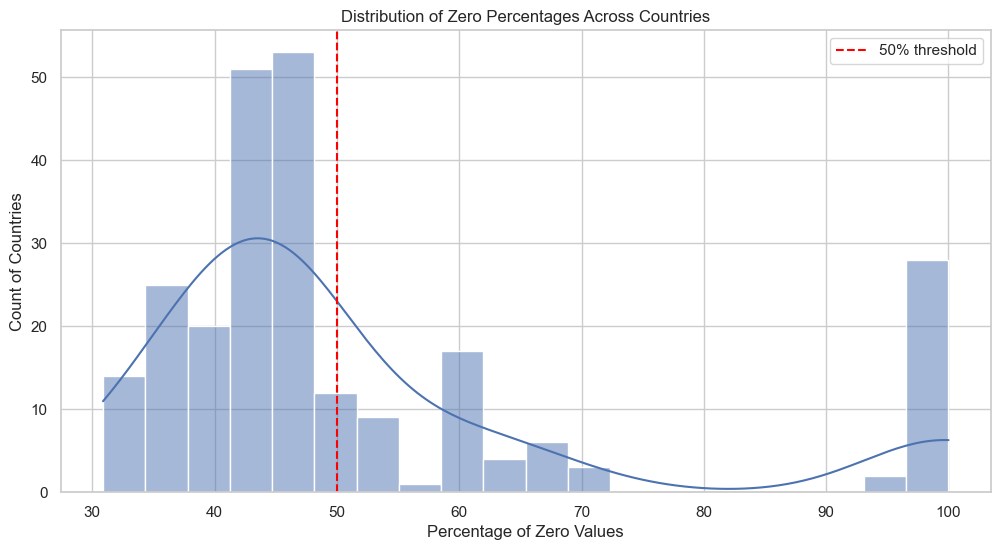

In [ ]:
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="whitegrid")
csv_files = glob.glob("../data/raw/**/*.csv", recursive=True)
countries_df = pd.read_csv('../data/util/countries.csv')
country_list = countries_df['name'].unique().tolist()

years = list(range(1970, 2026))

# Create the base DataFrame with all countries and years
base_data = []
for country in country_list:
    for year in years:
        base_data.append({"Entity": country, "Year": year})

merged_df = pd.DataFrame(base_data)

# Merging
for file in csv_files:
    try:
        df = pd.read_csv(file)
        df = df.drop(columns=['Code'], errors='ignore')
        merged_df = pd.merge(merged_df, df, on=['Entity', 'Year'], how='left')
    except Exception as e:
        print(f"Failed to process {file}: {e}")
        continue

merged_df = merged_df.fillna(0)
data_columns = [col for col in merged_df.columns if col not in ['Entity', 'Year']]

print(f"\nBefore filtering: {merged_df.shape[0]} rows, {merged_df['Entity'].nunique()} unique entities")

entity_zero_percentages = {}

for entity in merged_df['Entity'].unique():
    entity_data = merged_df[merged_df['Entity'] == entity][data_columns]
    total_cells = entity_data.size
    zero_cells = (entity_data == 0).sum().sum()
    zero_percentage = (zero_cells / total_cells) * 100
    entity_zero_percentages[entity] = zero_percentage
    
zero_percent_df = pd.DataFrame(list(entity_zero_percentages.items()), 
                               columns=['Entity', 'ZeroPercentage'])
zero_percent_df = zero_percent_df.sort_values('ZeroPercentage', ascending=False)

print("\nEntities with highest percentage of zeros:")
print(zero_percent_df.head(10))

entities_to_keep = [entity for entity, percentage in entity_zero_percentages.items() 
                    if percentage <= 50]

print(f"\nKeeping {len(entities_to_keep)} entities with 50% or less zeros")

# Filter the dataframe to keep only these entities
filtered_df = merged_df[merged_df['Entity'].isin(entities_to_keep)]

# Display information about the final filtered DataFrame
print("\nFiltered DataFrame:")
print(f"Shape: {filtered_df.shape}")
print(f"Columns: {filtered_df.columns.tolist()}")
print(f"Years range: {filtered_df['Year'].min()} to {filtered_df['Year'].max()}")
print(f"Number of unique entities: {filtered_df['Entity'].nunique()}")


# Visualize the distribution of zero percentages
plt.figure(figsize=(12, 6))
sns.histplot(zero_percent_df['ZeroPercentage'], bins=20, kde=True)
plt.axvline(x=50, color='red', linestyle='--', label='50% threshold')
plt.title('Distribution of Zero Percentages Across Countries')
plt.xlabel('Percentage of Zero Values')
plt.ylabel('Count of Countries')
plt.legend()
filtered_df.to_csv("../data/generated/filtered_dataset.csv", index=False)

# Additional analysis: How many entities were removed by percentage threshold
entities_removed = len(entity_zero_percentages) - len(entities_to_keep)
removal_percentage = (entities_removed / len(entity_zero_percentages)) * 100
print(f"\nRemoved {entities_removed} entities ({removal_percentage:.2f}% of total)")
